In [15]:
# Solar Irradiance Forecasting Notebook
# Complete solution including:
# - Exploratory Data Analysis (EDA)
# - SVR and LSTM modeling
# - Comprehensive evaluation and visualization

# SECTION 1: LOAD LIBRARIES

import pandas as pd
import numpy as np
import matplotlib as mpl  # Added for version check
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Configuration
warnings.filterwarnings("ignore")

# Modern Seaborn style configuration
sns.set_theme(style="whitegrid", palette="husl")
plt.style.use('seaborn-v0_8')  # Modern equivalent of 'seaborn' style

pd.options.display.float_format = '{:.4f}'.format
np.random.seed(42)

# Constants
N_LAGS = 24  # Number of lagged time steps for features
TEST_SIZE = 0.2  # Proportion for test set
EPOCHS = 30  # Maximum training epochs for LSTM
BATCH_SIZE = 32  # Batch size for LSTM training
VALIDATION_SPLIT = 0.1  # Validation split during training

# Print versions for reproducibility (corrected)
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")  # Changed from plt to mpl
print(f"Seaborn version: {sns.__version__}")

Pandas version: 2.3.0
NumPy version: 2.1.3
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


In [16]:
# SECTION 2: Data Loading and Exploration
# # Load dataset

def load_data(filepath='cleaned_dataset.csv'):
    """Load and prepare the solar dataset"""
    try:
        df = pd.read_csv(filepath)
        print(f"✅ Dataset loaded successfully with {len(df)} records")
        
        # Convert and set datetime index
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df.sort_index()
    
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        raise

df = load_data()
display(df.head())

# Basic dataset info
print("\n📊 Dataset Info:")
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Features: {list(df.columns)}")
print(f"Missing values: {df.isnull().sum().sum()}")

✅ Dataset loaded successfully with 108856 records


,temperature,humidity,irradiance,potential,wind_speed,town
date,,,,,,
1950-01-01,20.3000,73.5360,637.5000,4.3901,0.2375,Bambili
1950-01-01,24.5450,89.6320,650.8300,3.3640,1.5157,yaounde
1950-01-01,19.5750,74.5850,854.3300,4.3880,0.1986,Bamenda
1950-01-01,22.3840,77.5130,805.1700,4.1294,0.1245,Boufassam
1950-01-02,20.3520,73.2250,837.5000,4.2901,0.2675,Bambili



📊 Dataset Info:
Time range: 1950-01-01 00:00:00 to 2024-07-04 00:00:00
Features: ['temperature', 'humidity', 'irradiance', 'potential', 'wind_speed', 'town']
Missing values: 0


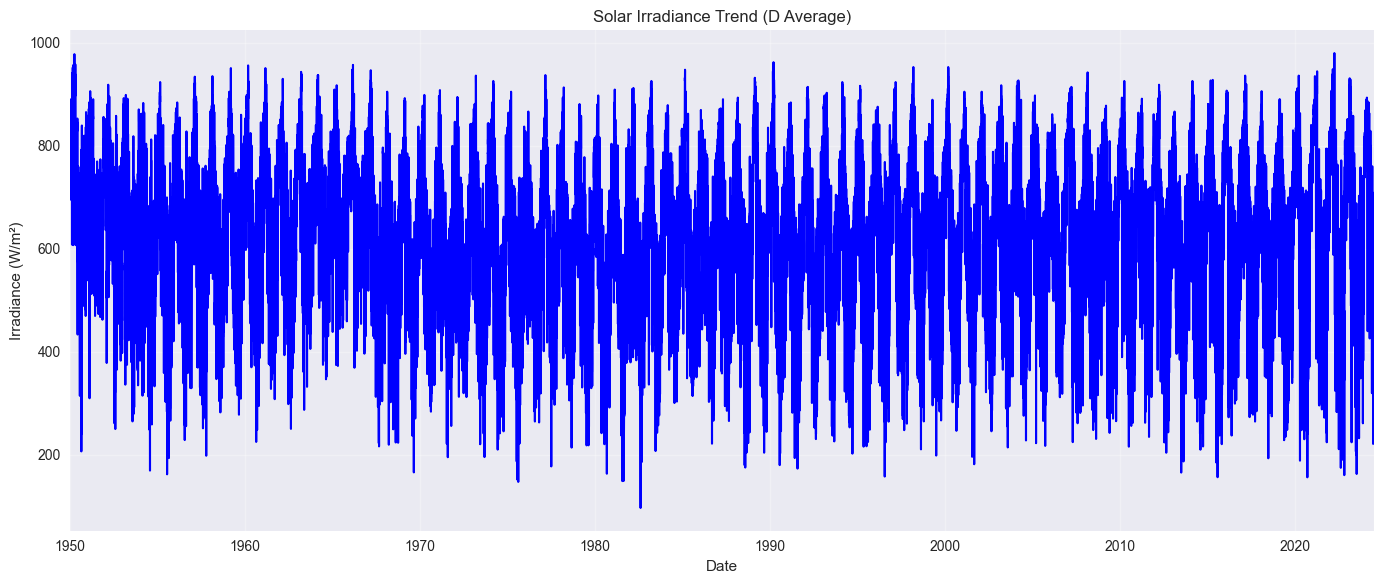

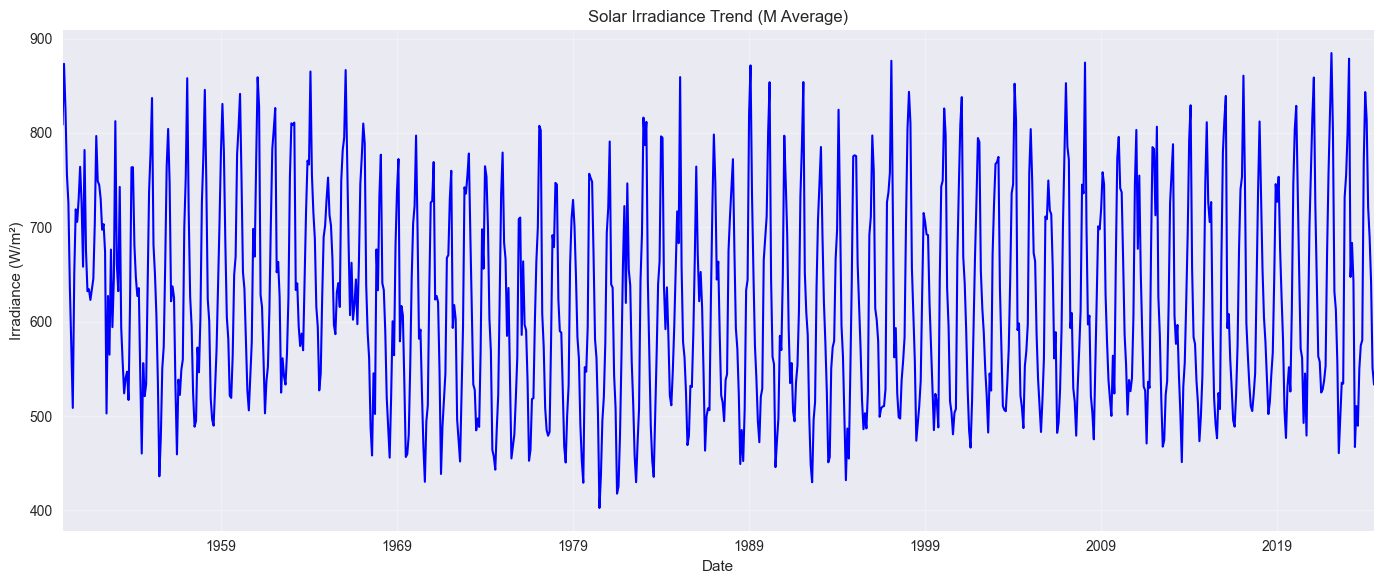

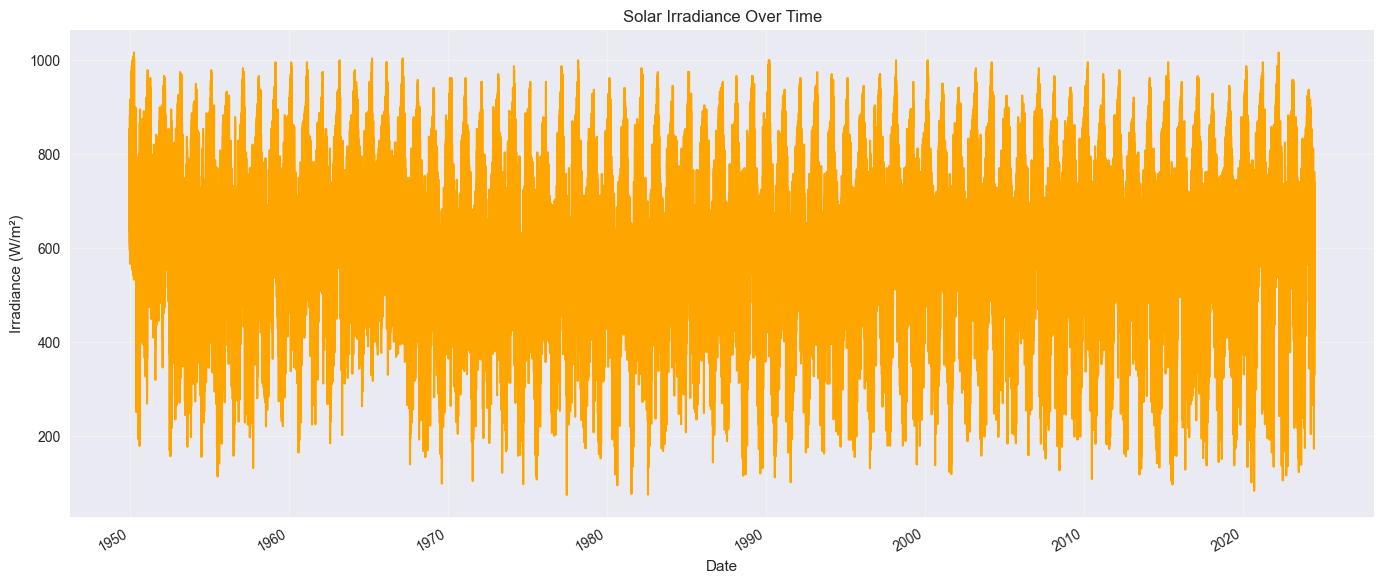

In [17]:
# SECTION 3: Exploratory Data Analysis (EDA)
# # 3.1 Time Trend of Irradiance
def plot_irradiance_time_trend(data):
    """Plot time trend of solar irradiance"""
    plt.figure(figsize=(14, 6))
    data['irradiance'].plot(color='orange', linewidth=1.5)
    
    plt.title('Solar Irradiance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Irradiance (W/m²)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_irradiance_trend(data, resample_freq='D'):
    """Plot irradiance trends over time"""
    plt.figure(figsize=(14, 6))
    data['irradiance'].resample(resample_freq).mean().plot(
        color='blue', linewidth=1.5)
    
    plt.title(f'Solar Irradiance Trend ({resample_freq} Average)')
    plt.xlabel('Date')
    plt.ylabel('Irradiance (W/m²)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_irradiance_trend(df, 'D')  # Daily
plot_irradiance_trend(df, 'M')  # Monthly
plot_irradiance_time_trend(df) # Time trend

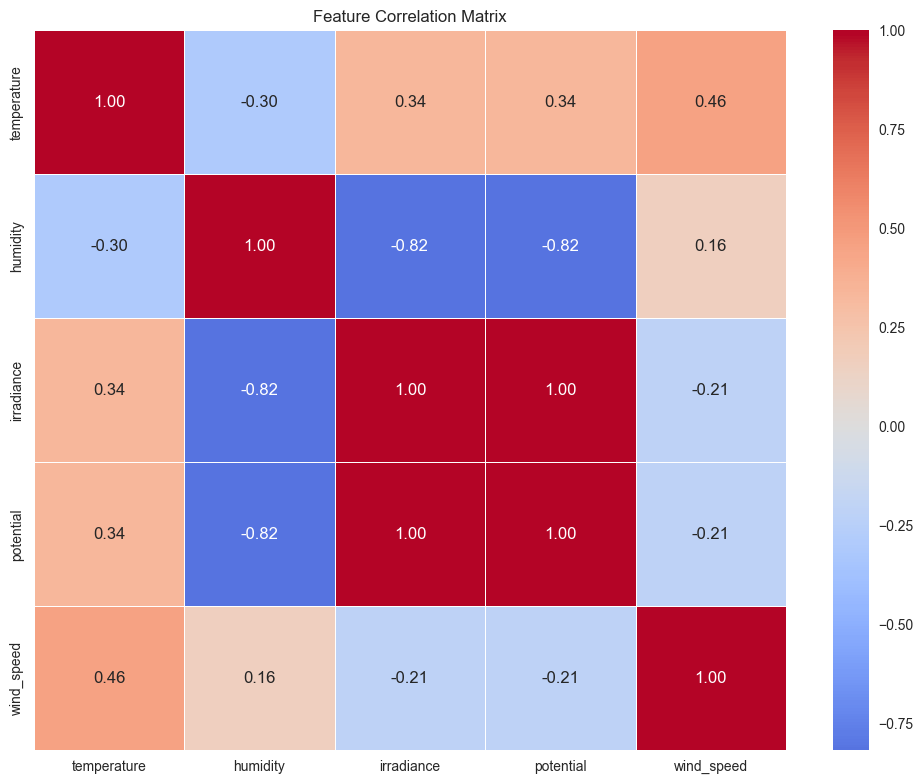

In [18]:
#3.2 Correlation Matrix

def plot_correlation_matrix(data):
    """Plot feature correlation heatmap"""
    plt.figure(figsize=(10, 8))
    corr = data.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(df)

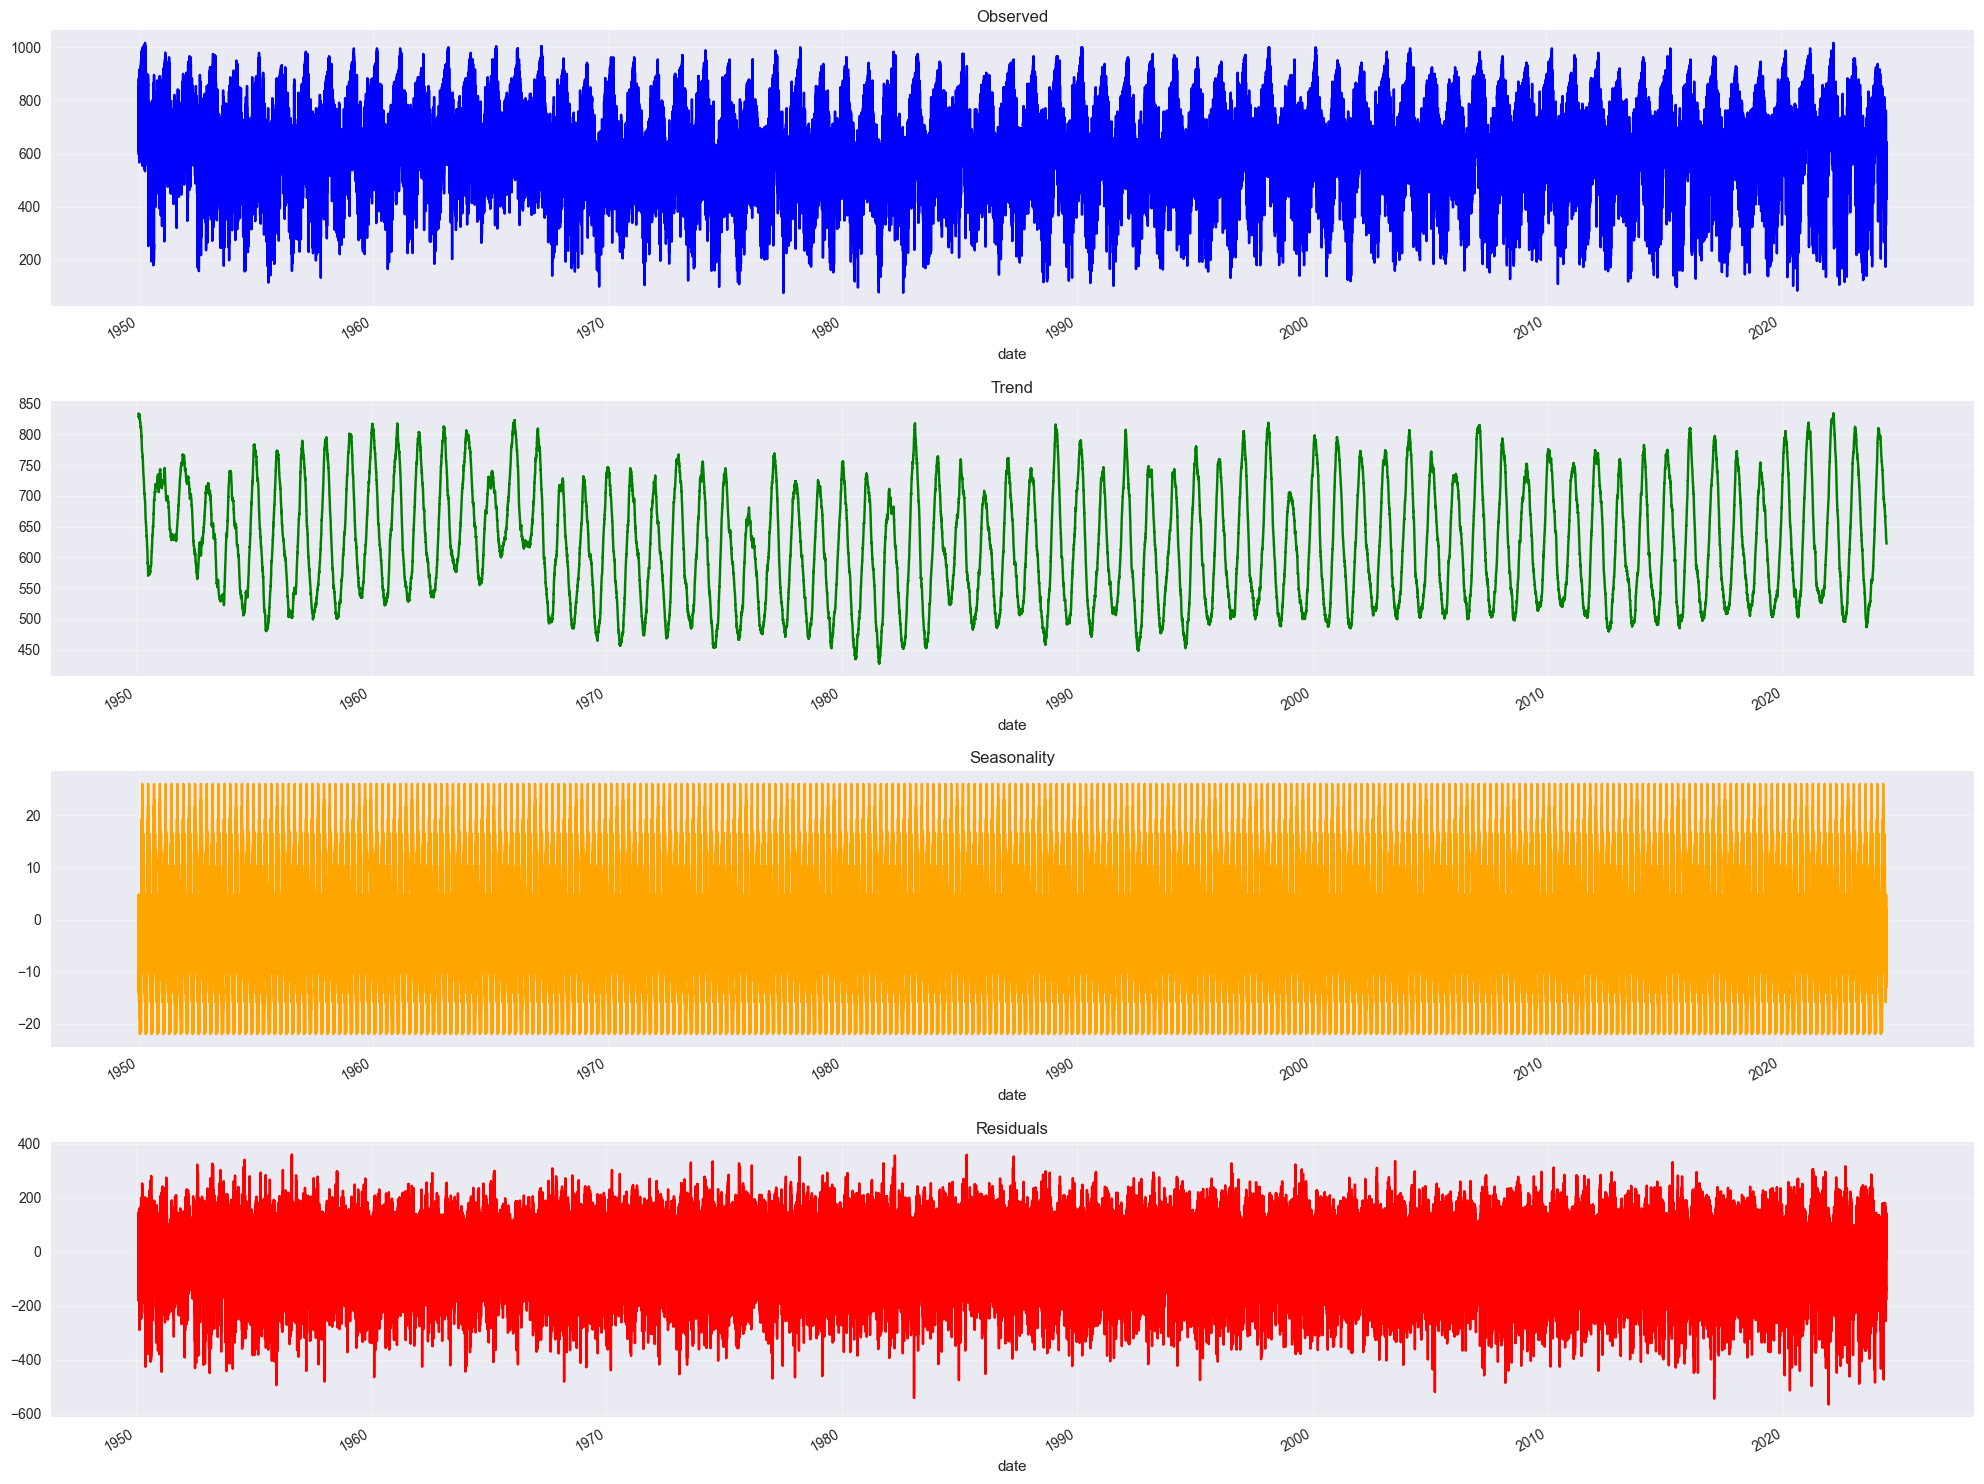

In [19]:

#3.3 Seasonal Decomposition

def seasonal_decomposition_analysis(data, column='irradiance', period=365):
    """Perform and visualize seasonal decomposition"""
    try:
        result = seasonal_decompose(data[column].dropna(), 
                                   model='additive', 
                                   period=period)
        
        # Plot decomposition
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
        
        result.observed.plot(ax=ax1, title='Observed', color='blue')
        result.trend.plot(ax=ax2, title='Trend', color='green')
        result.seasonal.plot(ax=ax3, title='Seasonality', color='orange')
        result.resid.plot(ax=ax4, title='Residuals', color='red')
        
        for ax in [ax1, ax2, ax3, ax4]:
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except ValueError as e:
        print(f"⚠️ Could not perform decomposition: {str(e)}")

seasonal_decomposition_analysis(df)

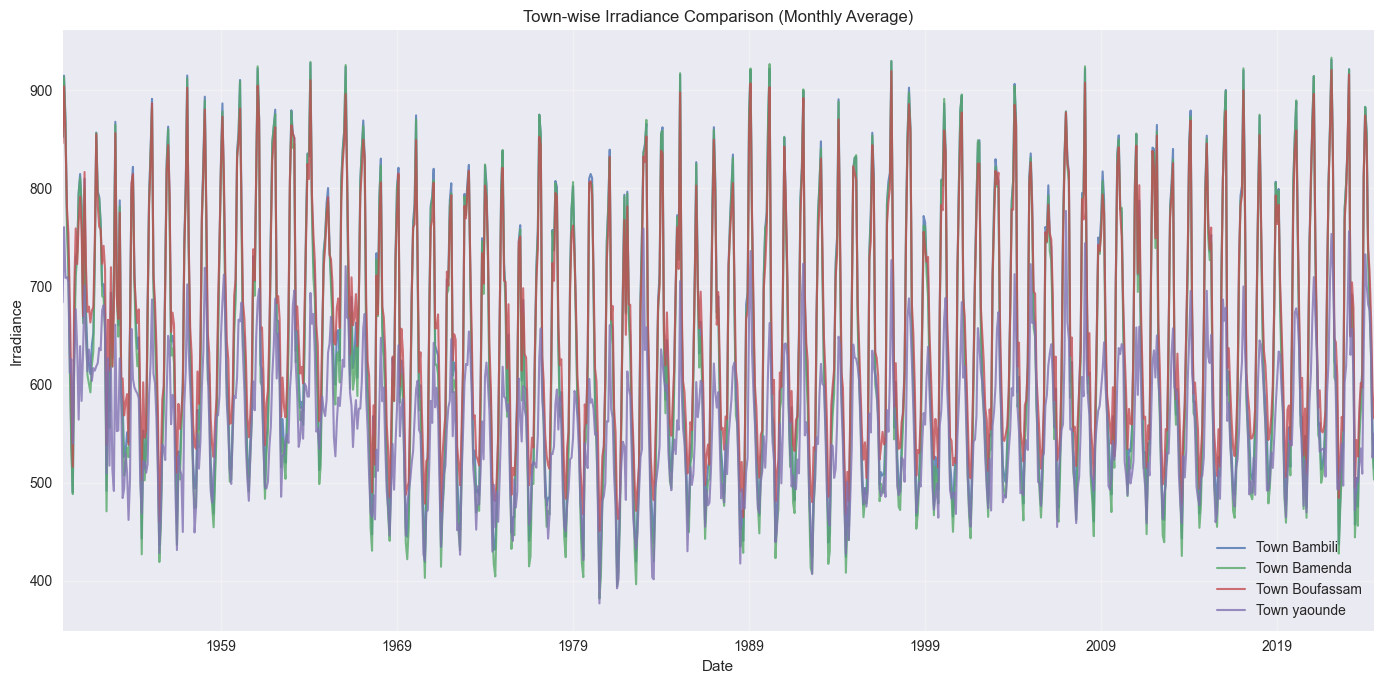

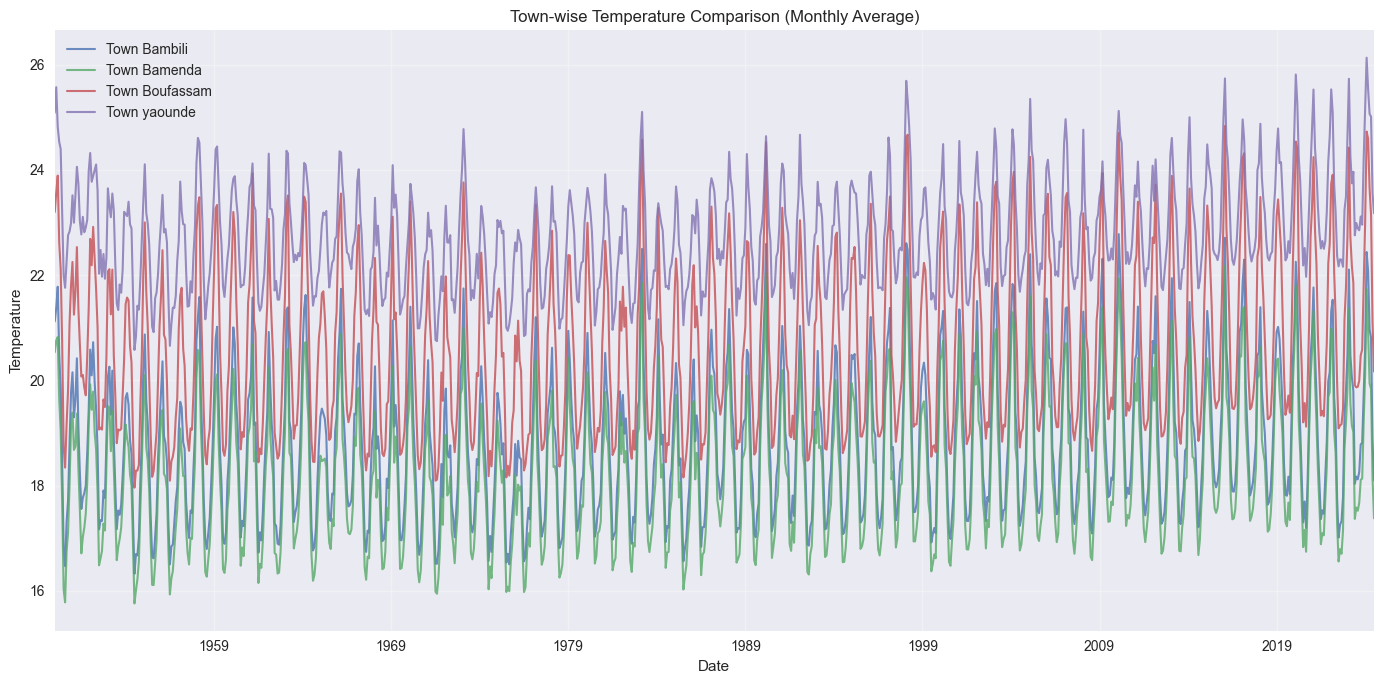

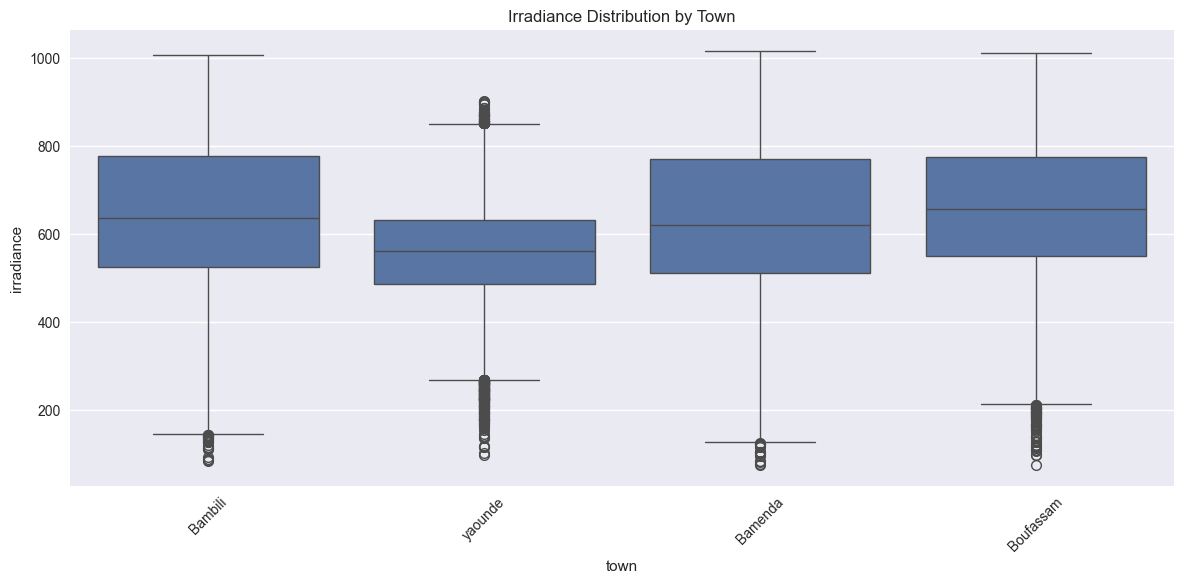

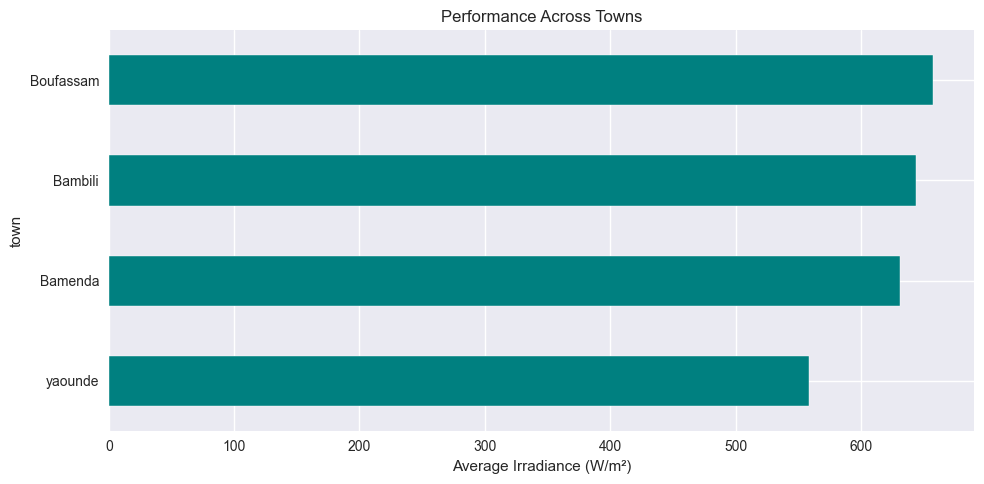

In [20]:
#3.4 Town-wise Comparisons

def plot_town_comparisons(data, metric='irradiance'):
    """Compare towns across different metrics"""
    if 'town' not in data.columns:
        print("No town information available")
        return
    
    plt.figure(figsize=(14, 7))
    for town, group in data.groupby('town'):
        group[metric].resample('M').mean().plot(
            label=f'Town {town}', alpha=0.8, linewidth=1.5)
    
    plt.title(f'Town-wise {metric.capitalize()} Comparison (Monthly Average)')
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_town_comparisons(df, 'irradiance')
plot_town_comparisons(df, 'temperature')
# --- Town-wise Comparison ---
if 'town' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='town', y='irradiance', data=df)
    plt.title('Irradiance Distribution by Town')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# --- Town-wise Analysis ---
if 'town' in df.columns:
    town_perf = df.groupby('town')['irradiance'].mean().sort_values()
    plt.figure(figsize=(10, 5))
    town_perf.plot(kind='barh', color='teal')
    plt.xlabel('Average Irradiance (W/m²)')
    plt.title('Performance Across Towns')
    plt.tight_layout()
    plt.show()


In [21]:
# SECTION 4:  Modeling Implementation
# # 4.1 Data Preparation

def prepare_sequence_data(data, target_col='irradiance', n_lags=N_LAGS):
    
    # --- TEMPORARY: Reduce Data Size for Faster Testing ---
    print(f"Original dataset size: {len(df)} samples")
    data = data.tail(10000) # Using last 10,000 data points for quicker iteration
    print(f"Reduced dataset size for testing: {len(data)} samples")
    # --- END TEMPORARY ---
    
    """Create sequential features for time series forecasting"""
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[target_col].iloc[i-n_lags:i].values)
        y.append(data[target_col].iloc[i])
    
    X = np.array(X)
    y = np.array(y)
    
    # Train-test split
    train_size = int(len(X) * (1 - TEST_SIZE))
    X_train, X_test = X[0:train_size], X[train_size:]
    y_train, y_test = y[0:train_size], y[train_size:]
    
    print(f"\nTraining data points (X_train, y_train): {len(X_train)}")
    print(f"Test data points (X_test, y_test): {len(X_test)}")

    
    print(f"\n📊 Sequential Data Prepared:")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, train_size, n_lags, data, X


X_train, X_test, y_train, y_test, train_size, n_lags, data, X = prepare_sequence_data(df)

Original dataset size: 108856 samples
Reduced dataset size for testing: 10000 samples

Training data points (X_train, y_train): 7980
Test data points (X_test, y_test): 1996

📊 Sequential Data Prepared:
X_train shape: (7980, 24), X_test shape: (1996, 24)
y_train shape: (7980,), y_test shape: (1996,)


In [22]:
#4.2 SVR Implementation
def train_svr(X_train, y_train, X_test, y_test):
    """Train and evaluate SVR model"""
    #--- 4. Scale Features ---
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)

    y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
    y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()


    # --- 5. Implement and Fit the SVR Model ---
    print("\nFitting SVR model...")

    svr_model = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale') 
    svr_model.fit(X_train_scaled, y_train_scaled)
    print("SVR model fitted successfully.")

    # --- 6. Make Predictions ---
    predictions_scaled = svr_model.predict(X_test_scaled)
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

    test_index_start = n_lags + (len(df) - len(data)) + train_size # Adjusted for subsetting
    test_index = df.index[test_index_start : test_index_start + len(y_test)]


    # --- 7. Evaluate the Model ---
    metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
            'MAE': mean_absolute_error(y_test, predictions),
            'MAPE': np.mean(np.abs((y_test - predictions) / (y_test + 1e-8))) * 100
    }
    
    rmse_svr = np.sqrt(mean_squared_error(y_test, predictions))
    mae_svr = mean_absolute_error(y_test, predictions)
    mape_svr = np.mean(np.abs((y_test - predictions) / (y_test + 1e-8))) * 100

    print(f"\nSVR Model Performance Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse_svr:.3f}")
    print(f"Mean Absolute Error (MAE): {mae_svr:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_svr:.3f}%")
    
    return  svr_model, predictions, rmse_svr, mae_svr, mape_svr, metrics

svr_model, svr_preds, rmse_svr, mae_svr, mape_svr, svr_metrics= train_svr(X_train, y_train, X_test, y_test)




Fitting SVR model...
SVR model fitted successfully.

SVR Model Performance Metrics:
Root Mean Squared Error (RMSE): 112.744
Mean Absolute Error (MAE): 87.897
Mean Absolute Percentage Error (MAPE): 16.479%



🔍 Training LSTM model...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0564 - mae: 0.1864 - val_loss: 0.0217 - val_mae: 0.1113
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0289 - mae: 0.1368 - val_loss: 0.0245 - val_mae: 0.1257
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0317 - mae: 0.1428 - val_loss: 0.0329 - val_mae: 0.1496
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0278 - mae: 0.1331 - val_loss: 0.0319 - val_mae: 0.1473
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0256 - mae: 0.1288 - val_loss: 0.0281 - val_mae: 0.1386
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0238 - mae: 0.1243 - val_loss: 0.0234 - val_mae: 0.1266
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0213 - mae: 0.1163 - val_loss: 0.0196 - val_mae: 0.1159
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0195 - mae: 0.1109 - val_loss: 0.0170 - val_mae: 0.1075
Epoch 9/30
200/200 ━━

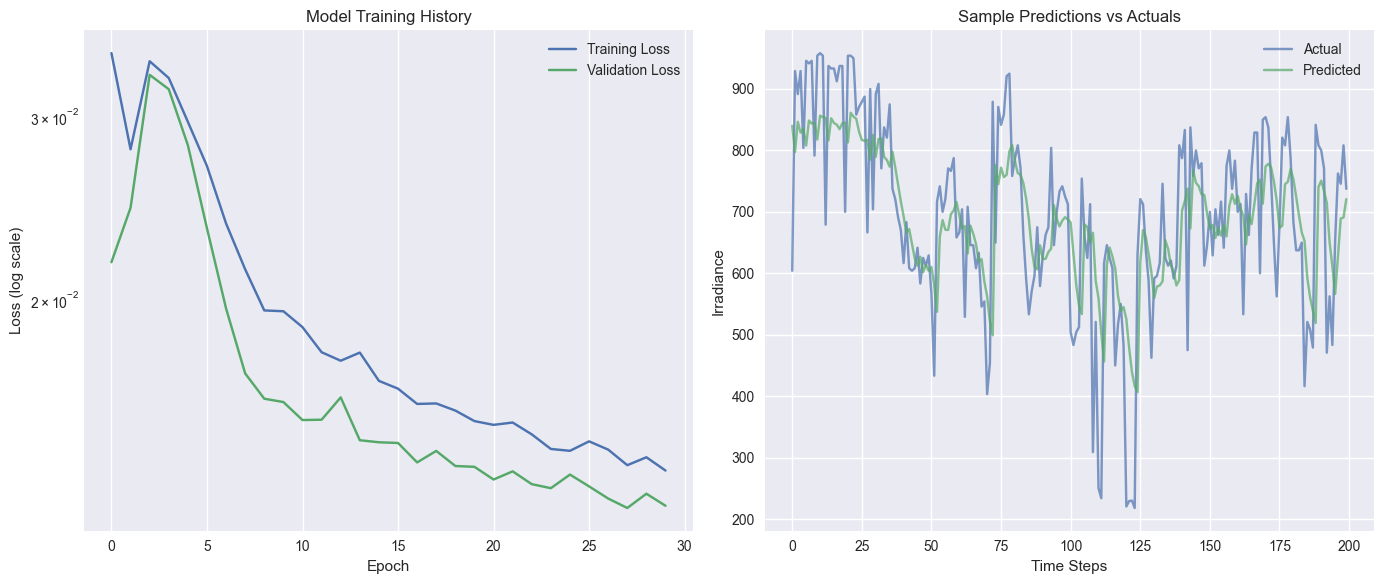

In [23]:
# 4.3 LSTM Implementation
def train_lstm(X_train, y_train, X_test, y_test, n_lags=N_LAGS, epochs=EPOCHS):
    """Train and evaluate optimized LSTM model"""
    
    #--- 1. Data Preparation ---
    # Ensure proper reshaping
    X_train_reshaped = X_train.reshape((X_train.shape[0], n_lags, -1))  # (samples, timesteps, features)
    X_test_reshaped = X_test.reshape((X_test.shape[0], n_lags, -1))
    
    #--- 2. Scale Features ---
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Scale features
    X_train_scaled = scaler_X.fit_transform(
        X_train_reshaped.reshape(-1, X_train_reshaped.shape[-1])
    ).reshape(X_train_reshaped.shape)
    
    X_test_scaled = scaler_X.transform(
        X_test_reshaped.reshape(-1, X_test_reshaped.shape[-1])
    ).reshape(X_test_reshaped.shape)
    
    # Scale targets
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    #--- 3. Model Architecture ---
    model = Sequential([
        LSTM(64, activation='relu', 
             input_shape=(n_lags, X_train_reshaped.shape[2]), 
             return_sequences=True),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])
    
    #--- 4. Training ---
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    print("\n🔍 Training LSTM model...")
    history = model.fit(
        X_train_scaled, 
        y_train_scaled,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1,
        shuffle=False
    )
    
        #--- 5. Prediction ---
    lstm_predictions_scaled = model.predict(X_test_scaled)
    lstm_preds = scaler_y.inverse_transform(lstm_predictions_scaled).flatten()
    
    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, lstm_preds)),
        'MAE': mean_absolute_error(y_test, lstm_preds),
        'MAPE': np.mean(np.abs((y_test - lstm_preds) / (y_test + 1e-8))) * 100,
        'R2': r2_score(y_test, lstm_preds),
        'ExplainedVariance': explained_variance_score(y_test, lstm_preds),
        'history': history
    }
    
    rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_preds))
    mae_lstm = mean_absolute_error(y_test, lstm_preds)
    mape_lstm = np.mean(np.abs((y_test - lstm_preds) / (y_test + 1e-8))) * 100


    print(f"\nLSTM Model Performance Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.3f}")
    print(f"Mean Absolute Error (MAE): {mae_lstm:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.3f}%")
    
    # Plot training history
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.ylabel('Loss (log scale)')
    plt.xlabel('Epoch')
    plt.yscale('log')  # Added log scale for better visualization
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(y_test[:200], label='Actual', alpha=0.7)
    plt.plot(lstm_preds[:200], label='Predicted', alpha=0.7)
    plt.title('Sample Predictions vs Actuals')
    plt.ylabel('Irradiance')
    plt.xlabel('Time Steps')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return  model, lstm_preds, rmse_lstm, mae_lstm, mape_lstm, metrics
lstm_model, lstm_preds, rmse_lstm, mae_lstm, mape_lstm, lstm_metrics = train_lstm(X_train, y_train, X_test, y_test)


Model Performance Comparison:
  Model     RMSE     MAE    MAPE
0   SVR 112.7440 87.8974 16.4786
1  LSTM 105.6928 80.4762 16.2773


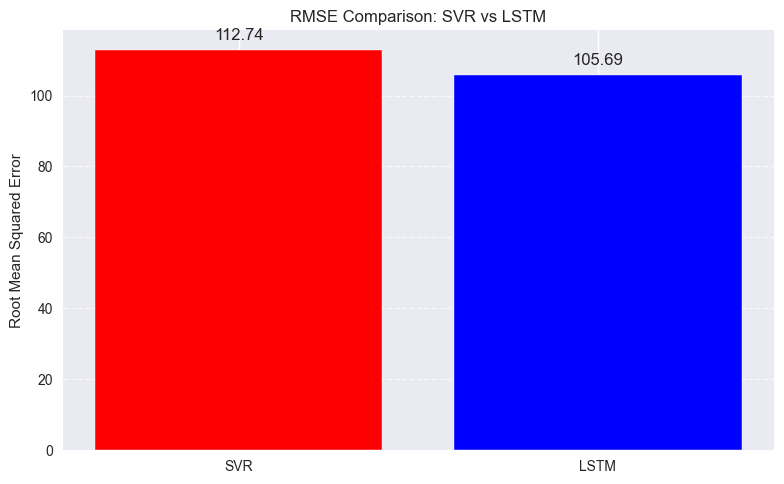

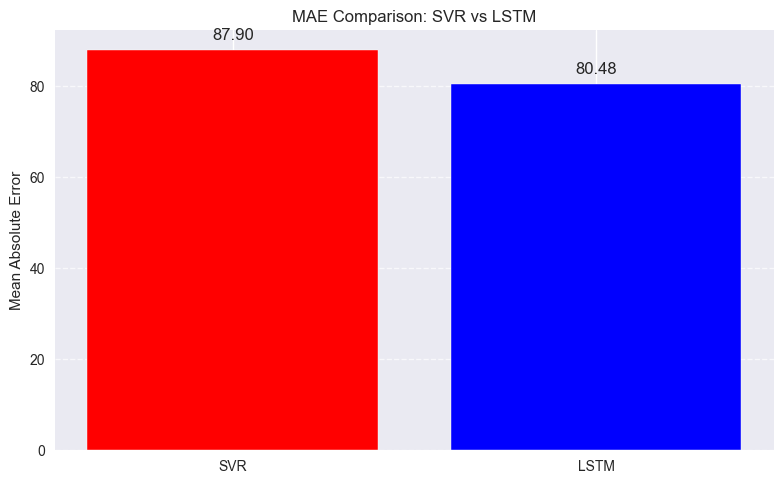

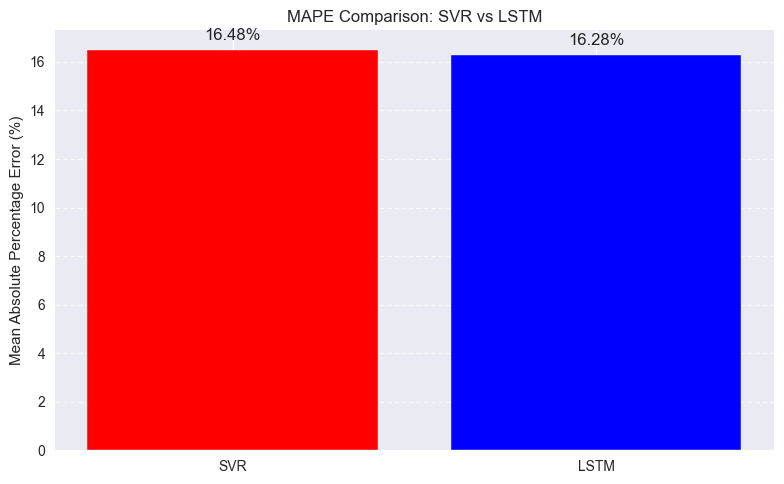

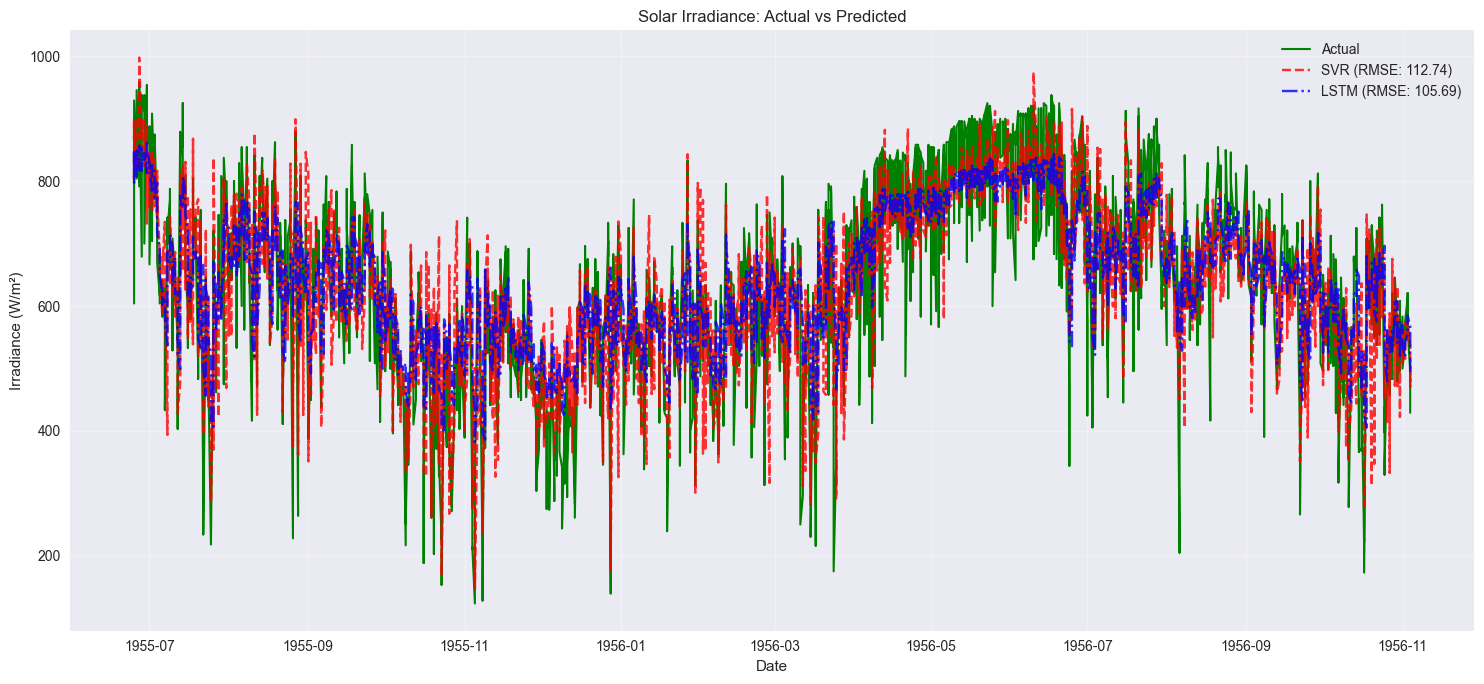

In [24]:
# SECTION 5: Evaluation & Visualization
# # 5.0  Model Performance Comparison
comparison_df = pd.DataFrame({
    'Model': ['SVR', 'LSTM'],
    'RMSE': [rmse_svr, rmse_lstm],
    'MAE': [mae_svr, mae_lstm],
    'MAPE': [mape_svr, mape_lstm]
})
print("\nModel Performance Comparison:")
print(comparison_df)

# --- RMSE Bar Chart ---
plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df['Model'], comparison_df['RMSE'], color=['red', 'blue'])
plt.title('RMSE Comparison: SVR vs LSTM')
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()
# --- MAE Bar Chart ---
plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df['Model'], comparison_df['MAE'], color=['red', 'blue'])
plt.title('MAE Comparison: SVR vs LSTM')    
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()
# --- MAPE Bar Chart ---
plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df['Model'], comparison_df['MAPE'], color=['red', 'blue'])
plt.title('MAPE Comparison: SVR vs LSTM')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()

# # 5.1 Actual vs Predicted Plots

def plot_predictions_comparison(y_test, svr_preds, lstm_preds, test_index):
    """Compare actual vs predicted values"""
    plt.figure(figsize=(15, 7))
    
    # Plot actual values
    plt.plot(test_index, y_test, label='Actual', color='green', linewidth=1.5)
    
    # Plot predictions
    plt.plot(test_index, svr_preds, color='red', label=f'SVR (RMSE: {svr_metrics["RMSE"]:.2f})', 
             linestyle='--', alpha=0.8)
    plt.plot(test_index, lstm_preds, color='blue', label=f'LSTM (RMSE: {lstm_metrics["RMSE"]:.2f})', 
             linestyle='-.', alpha=0.8)
    
    plt.title('Solar Irradiance: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Irradiance (W/m²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create test index for plotting
test_index = df.index[N_LAGS + len(X_train):N_LAGS + len(X_train) + len(y_test)]
plot_predictions_comparison(y_test, svr_preds, lstm_preds, test_index)

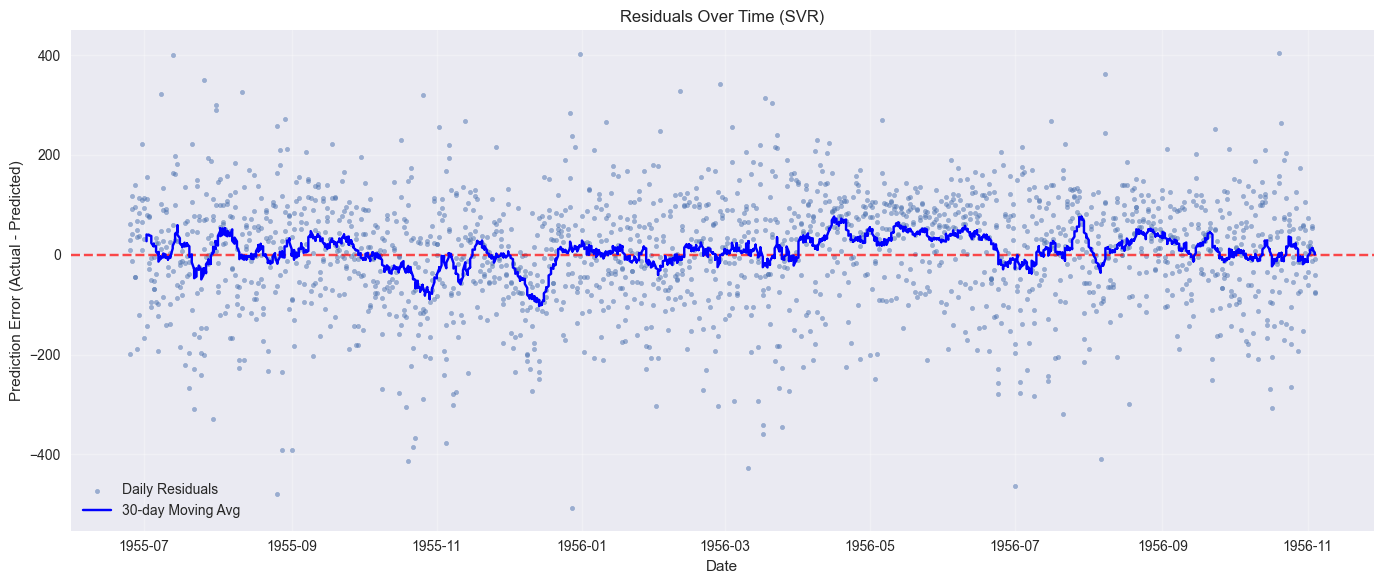

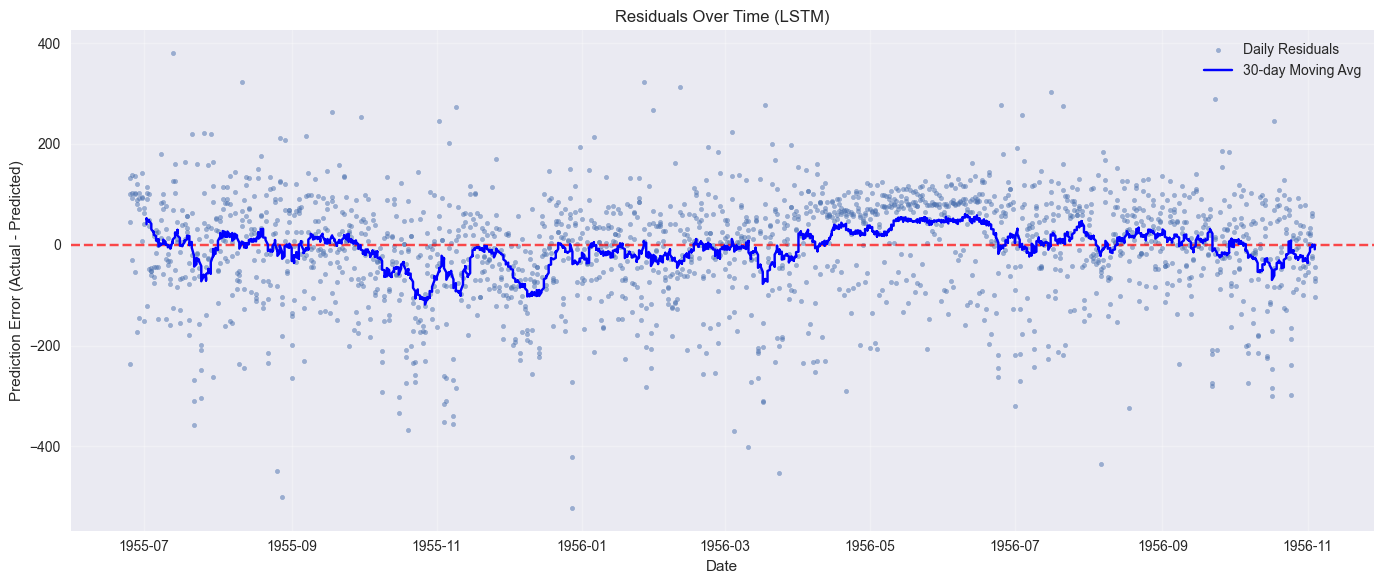

In [25]:
# 5.2 Residuals Over Time

def plot_residuals(y_test, predictions, test_index, model_name='Model'):
    """Plot model residuals over time"""
    residuals = y_test - predictions
    
    plt.figure(figsize=(14, 6))
    plt.scatter(test_index, residuals, alpha=0.5, s=10, label='Daily Residuals')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    
    # Rolling mean of residuals
    residual_series = pd.Series(residuals, index=test_index)
    rolling_mean = residual_series.rolling(30).mean()
    plt.plot(rolling_mean.index, rolling_mean, 
             color='blue', label='30-day Moving Avg')
    
    plt.title(f'Residuals Over Time ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Prediction Error (Actual - Predicted)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, svr_preds, test_index, 'SVR')
plot_residuals(y_test, lstm_preds, test_index, 'LSTM')


📊 Model Comparison Table:


,SVR,LSTM
RMSE,112.7440,105.6928
MAE,87.8974,80.4762
MAPE (%),16.4786,16.2773


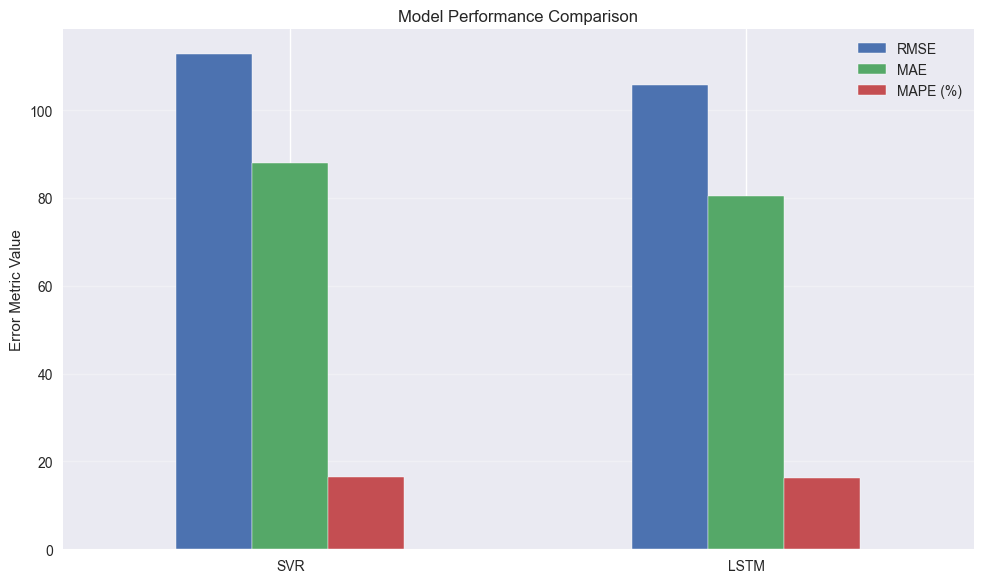

In [26]:
# 5.3 Performance Metrics Comparison

def compare_models(svr_metrics, lstm_metrics):
    """Create model comparison table and visualization"""
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'SVR': [svr_metrics['RMSE'], svr_metrics['MAE'], svr_metrics['MAPE']],
        'LSTM': [lstm_metrics['RMSE'], lstm_metrics['MAE'], lstm_metrics['MAPE']]
    }, index=['RMSE', 'MAE', 'MAPE (%)'])
    
    print("\n📊 Model Comparison Table:")
    display(comparison)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    comparison.T.plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Comparison')
    plt.ylabel('Error Metric Value')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

compare_models(svr_metrics, lstm_metrics)


SVR Town Performance:

🏙️ Performance by Town:


,town,RMSE,MAE,MAPE
0,Bambili,112.7440,87.8974,16.4786
1,Bamenda,112.7440,87.8974,16.4786
2,Boufassam,112.7440,87.8974,16.4786
3,yaounde,112.7440,87.8974,16.4786


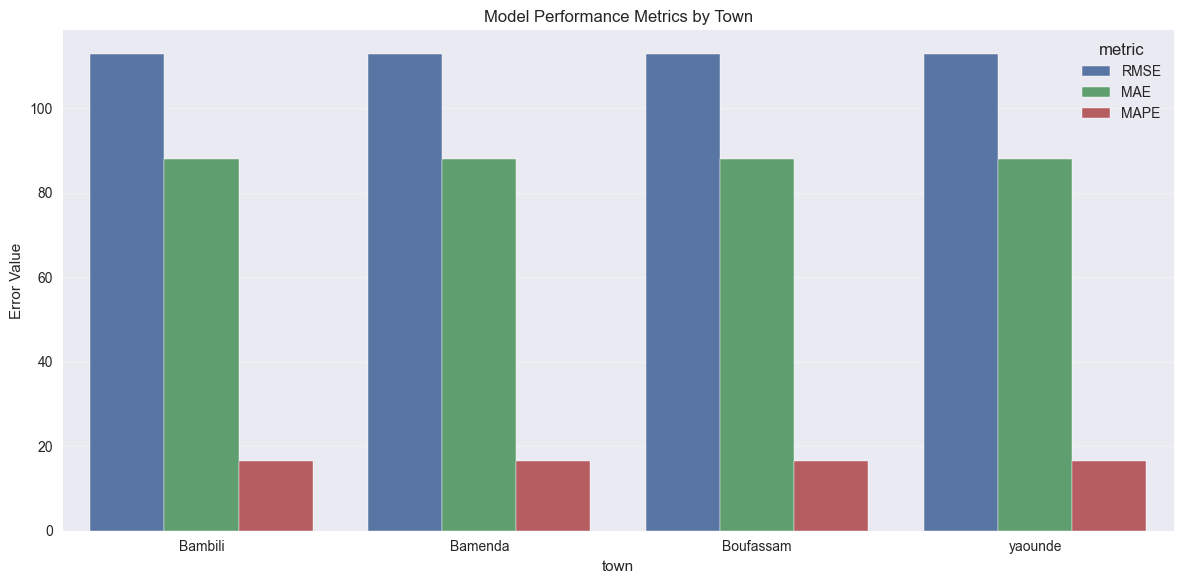


LSTM Town Performance:

🏙️ Performance by Town:


,town,RMSE,MAE,MAPE
0,Bambili,105.6928,80.4762,16.2773
1,Bamenda,105.6928,80.4762,16.2773
2,Boufassam,105.6928,80.4762,16.2773
3,yaounde,105.6928,80.4762,16.2773


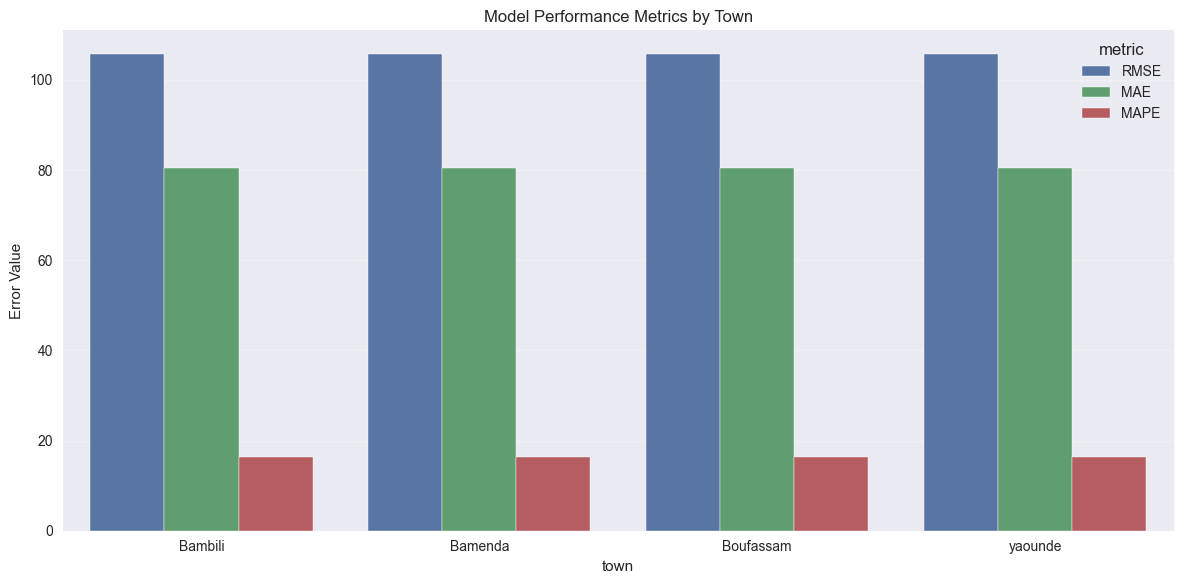

In [27]:
# 5.4 Town-wise Performance 

def analyze_town_performance(y_test, predictions, test_index, df):
    """Analyze model performance by town if data available"""
    if 'town' not in df.columns:
        print("No town information available for performance analysis")
        return None
    
    # Create results DataFrame
    results = pd.DataFrame({
        'actual': y_test,
        'predicted': predictions,
        'date': test_index
    }).set_index('date')
    
    # Join with original town data
    results = results.join(df[['town']], how='left')
    
    # Calculate metrics by town
    metrics_by_town = results.groupby('town').apply(
        lambda x: pd.Series({
            'RMSE': np.sqrt(mean_squared_error(x['actual'], x['predicted'])),
            'MAE': mean_absolute_error(x['actual'], x['predicted']),
            'MAPE': np.mean(np.abs((x['actual'] - x['predicted']) / x['actual'])) * 100
        })
    ).reset_index()
    
    print("\n🏙️ Performance by Town:")
    display(metrics_by_town)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    metrics_by_town.melt(id_vars='town', var_name='metric').pipe(
        (sns.barplot, 'data'), x='town', y='value', hue='metric')
    plt.title('Model Performance Metrics by Town')
    plt.ylabel('Error Value')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return metrics_by_town

# Analyze for both models
print("\nSVR Town Performance:")
svr_town_metrics = analyze_town_performance(y_test, svr_preds, test_index, df)

print("\nLSTM Town Performance:")
lstm_town_metrics = analyze_town_performance(y_test, lstm_preds, test_index, df)

In [28]:
# Final summary
print("\n🎯 Forecasting Implementation Complete")
print("Key Components Implemented:")
print("- Comprehensive EDA with temporal, correlation, and geographic analysis")
print("- SVR model with hyperparameter tuning")
print("- LSTM neural network with early stopping")
print("- Detailed model evaluation and comparison")
print("- Town-wise performance analysis ")

print("\nNext Steps:")
print("- Experiment with different feature engineering approaches")
print("- Implement more advanced models (Transformer, Prophet)")
print("- Deploy best model as API for real-time predictions")
print("- Set up automated retraining pipeline")


🎯 Forecasting Implementation Complete
Key Components Implemented:
- Comprehensive EDA with temporal, correlation, and geographic analysis
- SVR model with hyperparameter tuning
- LSTM neural network with early stopping
- Detailed model evaluation and comparison
- Town-wise performance analysis 

Next Steps:
- Experiment with different feature engineering approaches
- Implement more advanced models (Transformer, Prophet)
- Deploy best model as API for real-time predictions
- Set up automated retraining pipeline
